In [ ]:
!pip install -q emoji
!pip install -q vncorenlp
!pip install -q datasets
!pip install -q transformers

# This must be the same version with tf
# If you face any error related to PyYAML, you can try some solutions below:
# - https://github.com/tensorflow/models/issues/11220#issuecomment-2159046381
# - https://github.com/tensorflow/models/issues/11051#issuecomment-1641934626
# - https://github.com/tensorflow/models/issues/11169#issuecomment-2118382411
!pip install -q tf-models-official

In [1]:
import os
import sys
os.environ['KERAS_BACKEND'] = 'jax' # Use JAX as the backend for a particularly fast train step 
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__

'2.10.1'

In [2]:
if 'COLAB_TPU_ADDR' in os.environ and os.environ['COLAB_TPU_ADDR']: 
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print('Using TPU:', tf.config.list_logical_devices('TPU'))
    
elif tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Using GPU:', tf.test.gpu_device_name())
    strategy = tf.distribute.MirroredStrategy()
    !nvcc -V
else: raise ValueError('Running on CPU is not recommended.')

Using GPU: /device:GPU:0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


# Constants Setup and Load the Data

In [3]:
TRAIN_PATH = r'../datasets/vlsp2018_hotel/1-VLSP2018-SA-Hotel-train.csv'
VAL_PATH = r'../datasets/vlsp2018_hotel/2-VLSP2018-SA-Hotel-dev.csv'
TEST_PATH = r'../datasets/vlsp2018_hotel/3-VLSP2018-SA-Hotel-test.csv'
PRETRAINED_MODEL = 'vinai/phobert-base'
MODEL_NAME = 'Hotel-v1' # Multitask model on Hotel domain

MAX_LENGTH = 256
BATCH_SIZE = 20
LEARNING_RATE = 2e-4
EPOCHS = 20

In [4]:
from processors.vlsp2018_processor import VLSP2018Loader
raw_datasets = VLSP2018Loader.load(TRAIN_PATH, VAL_PATH, TEST_PATH)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATUR

# Preprocess and Tokenize the Data

In [5]:
from processors.vietnamese_processor import VietnameseTextPreprocessor
extra_acronyms = { 
    'khách sạn': ['ks', 'khach san'], 'nhà hàng': ['nhahang', 'nhà hàg'],
    'nhân viên': ['nv', 'nhân vien'], 'phòng': ['phong'], 'giá': ['price', 'gia'],

    'cửa hàng': ['store', 'sop', 'shopE', 'shop'], 
    'sản phẩm': ['sp', 'product'], 'hàng': ['hàg'],
    'giao hàng': ['ship', 'delivery', 'síp'], 'đặt hàng': ['order'], 
    'chất lượng': ['quality', 'chất lg'], 'chuẩn chính hãng': ['authentic', 'aut', 'auth'], 'hạn sử dụng': ['date', 'hsd'],

    'điện thoại': ['dt'],  'facebook': ['fb', 'face'],  
    'nhắn tin': ['nt', 'ib'], 'trả lời': ['tl', 'trl', 'rep'], 
    'feedback': ['fback', 'fedback'], 'sử dụng': ['sd'], 'xài': ['sài'], 
}
vn_preprocessor = VietnameseTextPreprocessor(vncorenlp_dir='../processors/VnCoreNLP', extra_acronyms=extra_acronyms)

VnCoreNLP word segmenter is loaded successfully.


In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokens = tokenizer.encode('Tôi là sinh_viên trường đại_học Công_nghệ thông_tin .') 
print('Encode:', tokens, '\nDecode:', tokenizer.decode(tokens))
tokenizer.model_input_names

c:\Users\QuanKun\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Encode: [0, 218, 8, 649, 212, 956, 2413, 195, 5, 2] 
Decode: <s> Tôi là sinh_viên trường đại_học Công_nghệ thông_tin. </s>


['input_ids', 'token_type_ids', 'attention_mask']

In [7]:
preprocessed_datasets = VLSP2018Loader.preprocess_and_tokenize(raw_datasets, vn_preprocessor, tokenizer, MAX_LENGTH)
preprocessed_datasets = VLSP2018Loader.labels_to_flatten_onehot(preprocessed_datasets)
preprocessed_datasets

[INFO] Preprocessing and tokenizing text data...


Map (num_proc=4):   0%|          | 0/3000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/600 [00:00<?, ? examples/s]

[INFO] Transforming "Aspect#Categoy,Polarity" labels to flattened one-hot encoding...


Map (num_proc=4):   0%|          | 0/3000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 600
    })
})

In [8]:
display(pd.DataFrame({
    'raw_datasets': raw_datasets['train']['Review'][:5], 
    'encoded_input_ids': preprocessed_datasets['train']['input_ids'][:5],
    'decoded_input_ids': [tokenizer.decode(preprocessed_datasets['train'][i]['input_ids']) for i in range(5)]
}))
print('Aspect#Category,Polarity in One-hot form of the first review:')
example_onehot = preprocessed_datasets['train'][0]['FlattenOneHotLabels']
np.array(example_onehot).reshape(-1, 4)

,raw_datasets,encoded_input_ids,decoded_input_ids
0,Rộng rãi KS mới nhưng rất vắng. Các dịch vụ ch...,"[0, 2616, 1299, 60, 51, 59, 3543, 9, 399, 390,...",<s> rộng_rãi khách_sạn mới nhưng rất vắng các ...
1,"Địa điểm thuận tiện, trong vòng bán kính 1,5km...","[0, 1501, 4798, 12, 323, 10802, 28668, 36, 946...",<s> địa_điểm thuận_tiện trong vòng bán_kính 15...
2,"Phục vụ, view đẹp, vị trí","[0, 533, 9328, 258, 442, 2, 1, 1, 1, 1, 1, 1, ...",<s> phục_vụ view đẹp vị_trí </s> <pad> <pad> <...
3,"thuận tiện , sạch sẽ , vui vẻ hài lòng","[0, 4798, 4767, 2164, 2273, 2, 1, 1, 1, 1, 1, ...",<s> thuận_tiện sạch_sẽ vui_vẻ hài_lòng </s> <p...
4,Vị trí đẹp; Có quán bar view đẹp; Nhân viên th...,"[0, 442, 258, 10, 946, 4445, 9328, 258, 650, 3...",<s> vị_trí đẹp có quán bar view đẹp nhân_viên ...


Aspect#Category,Polarity in One-hot form of the first review:


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

# Prepare for TensorFlow Training

In [9]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')
ASPECT_CATEGORY_NAMES = raw_datasets['train'].column_names[1:]
STEPS_PER_EPOCH = len(preprocessed_datasets['train']) // BATCH_SIZE
VALIDATION_STEPS = len(preprocessed_datasets['val']) // BATCH_SIZE

In [10]:
train_tf_dataset = preprocessed_datasets['train'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)
val_tf_dataset = preprocessed_datasets['val'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

In [150]:
from official.nlp import optimization
num_train_steps = STEPS_PER_EPOCH * EPOCHS
optimizer = optimization.create_optimizer(
    init_lr = LEARNING_RATE, 
    num_train_steps = num_train_steps, 
    num_warmup_steps = num_train_steps // 10
)
type(optimizer)

official.modeling.optimization.legacy_adamw.AdamWeightDecay

# Fine-tuning with TensorFlow

In [13]:
from model import vlsp2018_multitask_model, plot_training_history
from tensorflow.keras.callbacks import EarlyStopping

with strategy.scope():
    model = vlsp2018_multitask_model(PRETRAINED_MODEL, MAX_LENGTH, ASPECT_CATEGORY_NAMES, optimizer)
    history = model.fit(
        train_tf_dataset, 
        validation_data = val_tf_dataset, 
        validation_steps = VALIDATION_STEPS,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = EPOCHS,
        callbacks = [
            EarlyStopping(
                monitor = 'val_loss', 
                min_delta = 1e-3, # Change that less than 1e-3, will count as no improvement
                patience = 5, # Stop if no improvement after 5 epochs
                restore_best_weights = True, # Restore weights from the epoch with the best value
                verbose = 1
            )
        ], verbose = 1
    ).history

    model.save_weights(f'./weights/{MODEL_NAME}.h5')
    plot_training_history(history)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/20


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


 72/300 [======>.......................] - ETA: 2:25 - loss: 0.4035

# Reload the Model

In [12]:
from model import vlsp2018_multitask_model
with strategy.scope():
    reloaded_model = vlsp2018_multitask_model(PRETRAINED_MODEL, MAX_LENGTH, ASPECT_CATEGORY_NAMES, optimizer)
    reloaded_model.load_weights(f'./weights/{MODEL_NAME}.h5')
    reloaded_model.evaluate(val_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


100/100 [==============================] - 33s 248ms/step - loss: 0.1980


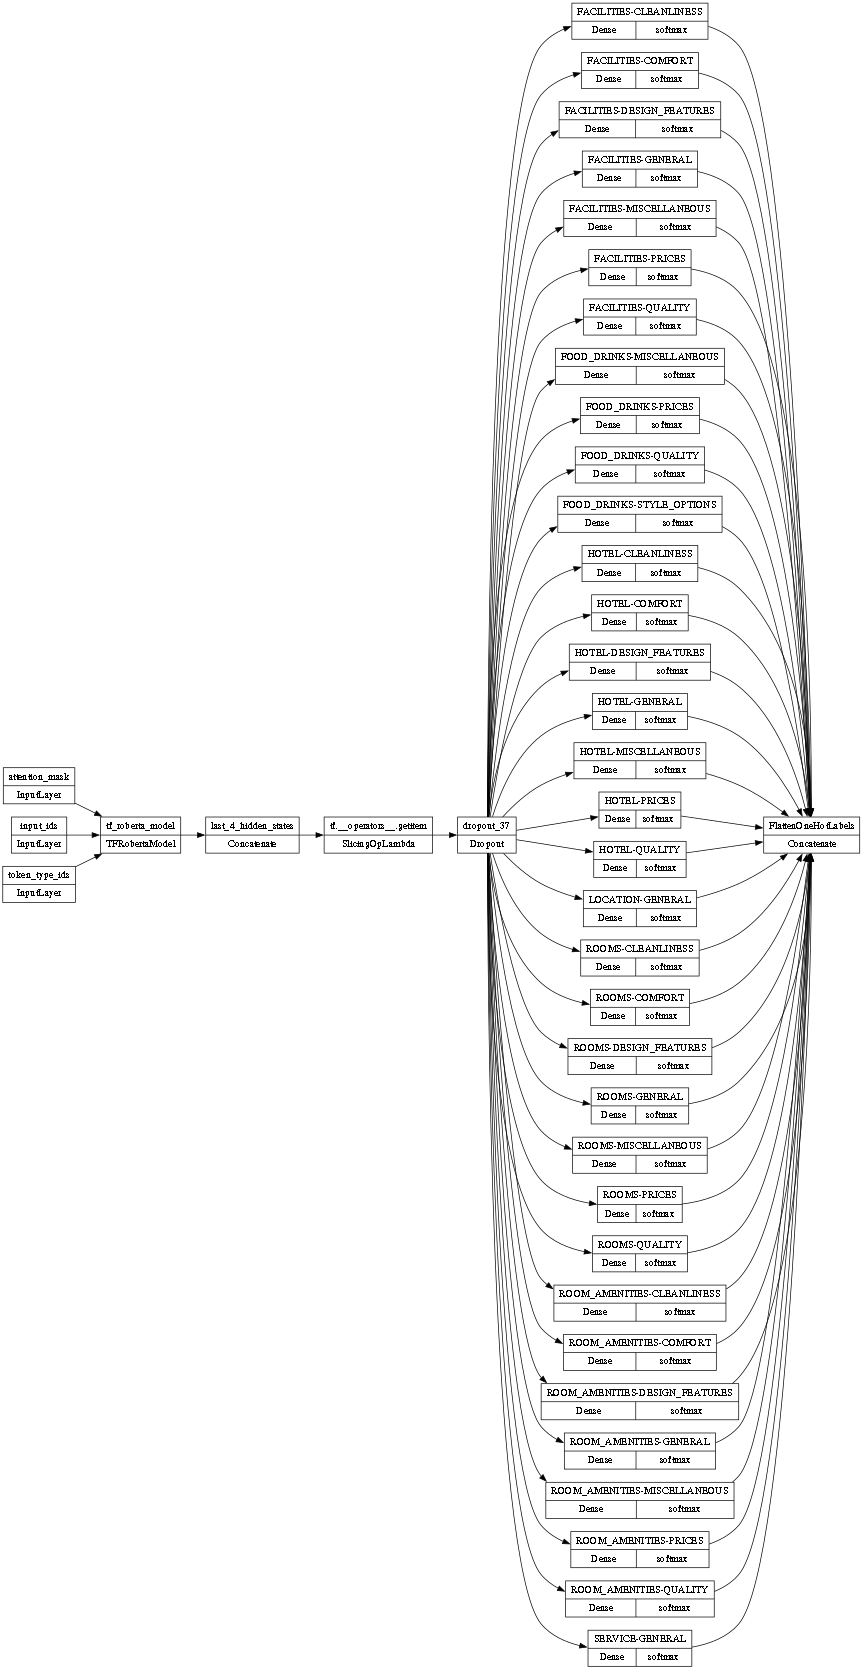

Model: "model"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 attention_mask (InputLayer)                     [(None, 256)]                    0                 []                                                
                                                                                                                                                      
 input_ids (InputLayer)                          [(None, 256)]                    0                 []                                                
                                                                                                                                                      
 token_type_ids (InputLayer)                     [(None, 256)]                 

In [13]:
from tensorflow.keras.utils import plot_model
display(plot_model(
    reloaded_model, to_file=f'{MODEL_NAME}.png', rankdir='LR', 
    expand_nested=True, dpi=50, show_layer_activations=True
))
reloaded_model.summary(line_length=150)

# Predict on the Test Data

In [14]:
from model import acsa_predict, print_acsa_pred
from tensorflow.data import Dataset 

test_tf_dataset = preprocessed_datasets['test'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

In [15]:
with strategy.scope(): # On test set
    y_pred = acsa_predict(reloaded_model, test_tf_dataset, BATCH_SIZE)
    reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)
    
print('Example:', raw_datasets['test'][0]['Review'])
print_acsa_pred(ASPECT_CATEGORY_NAMES, y_pred[0])

30/30 [==============================] - 14s 236ms/step
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


30/30 [==============================] - 12s 253ms/step - loss: 0.2609
Example: Ga giường không sạch, nhân viên quên dọn phòng một ngày.
=> SERVICE#GENERAL,negative


In [18]:
with strategy.scope(): # On a random review by user
    random_input = VLSP2018Loader.preprocess_and_tokenize(input('Enter your review: '), vn_preprocessor, tokenizer, MAX_LENGTH)
    tf_inputs = Dataset.from_tensor_slices({x: [[random_input[x]]] for x in tokenizer.model_input_names})
    random_pred = acsa_predict(reloaded_model, tf_inputs)
    print_acsa_pred(ASPECT_CATEGORY_NAMES, random_pred[0])

[INFO] Preprocessing and tokenizing text data...
1/1 [==============================] - 2s 2s/step
=> HOTEL#PRICES,positive
=> SERVICE#GENERAL,negative


# SkLearn Evaluation

In [16]:
y_test = np.array(preprocessed_datasets['test']['FlattenOneHotLabels'])
y_test = np.argmax(y_test.reshape(len(y_test), -1, 4), axis=-1)
y_test

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [128]:
from evaluators.sklearn_evaluator import VLSP2018SklearnEvaluator
sk_eval = VLSP2018SklearnEvaluator(y_test, y_pred, ASPECT_CATEGORY_NAMES)
# sk_eval.report(report_type='Aspect#Category,Polarity').round(3)
# sk_eval.report(report_type='Aspect#Category').round(3)
# sk_eval.report(report_type='Polarity').round(3)
# sk_eval.report(report_type='macro_avg').round(3)
sk_eval.report(report_type='all')

100%|██████████| 37/37 [00:00<?, ?it/s]


ACSA Report (w/o "None" polarity) 
 Aspect#Category 
 Aspect#Category,Polarity 
 
 
 precision recall f1-score support precision recall f1-score support 
 
 
 
 FACILITIES#CLEANLINESS,negative 
 1.000 0.400 0.571 5.0 
 1.000 0.667 0.800 3.0 
 
 
 
 FACILITIES#CLEANLINESS,positive 
 
 1.000 0.000 0.000 2.0 
 
 
 
 FACILITIES#COMFORT,negative 
 0.600 0.115 0.194 26.0 
 1.000 0.000 0.000 6.0 
 
 
 
 FACILITIES#COMFORT,positive 
 
 0.600 0.150 0.240 20.0 
 
 
 
 FACILITIES#DESIGN&FEATURES,negative 
 0.750 0.600 0.667 65.0 
 0.538 0.636 0.583 22.0 
 
 
 
 FACILITIES#DESIGN&FEATURES,positive 
 
 0.654 0.447 0.531 38.0 
 
 
 
 FACILITIES#DESIGN&FEATURES,neutral 
 
 1.000 0.000 0.000 5.0 
 
 
 
 FACILITIES#GENERAL,negative 
 0.556 0.476 0.513 21.0 
 0.500 1.000 0.667 1.0 
 
 
 
 FACILITIES#GENERAL,positive 
 
 0.562 0.474 0.514 19.0 
 
 
 
 FACILITIES#GENERAL,neutral 
 
 1.000 0.000 0.000 1.0 
 
 
 
 FACILITIES#MISCELLANEOUS,negative 
 1.000 0.000 0.000 8.0 
 1.000 0.000 0.000 5.0 
 
 
 
 FACILITIES#MISCELLANEOUS,positive 
 
 1.000 0.000 0.000 3.0 
 
 
 
 FACILITIES#PRICES,negative 
 0.538 0.538 0.538 13.0 
 0.500 0.333 0.400 3.0 
 
 
 
 FACILITIES#PRICES,positive 
 
 0.455 0.625 0.526 8.0 
 
 
 
 FACILITIES#PRICES,neutral 
 
 1.000 0.000 0.000 2.0 
 
 
 
 FACILITIES#QUALITY,negative 
 0.879 0.569 0.690 51.0 
 0.789 0.600 0.682 25.0 
 
 
 
 FACILITIES#QUALITY,positive 
 
 0.786 0.458 0.579 24.0 
 
 
 
 FACILITIES#QUALITY,neutral 
 
 1.000 0.000 0.000 2.0 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,negative 
 1.000 0.000 0.000 3.0 
 1.000 0.000 0.000 2.0 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,positive 
 
 1.000 0.000 0.000 1.0 
 
 
 
 FOOD&DRINKS#PRICES,negative 
 0.600 0.667 0.632 9.0 
 0.500 0.667 0.571 3.0 
 
 
 
 FOOD&DRINKS#PRICES,positive 
 
 0.667 0.667 0.667 6.0 
 
 
 
 FOOD&DRINKS#QUALITY,negative 
 0.950 0.891 0.920 129.0 
 0.833 0.789 0.811 19.0 
 
 
 
 FOOD&DRINKS#QUALITY,positive 
 
 0.926 0.917 0.921 96.0 
 
 
 
 FOOD&DRINKS#QUALITY,neutral 
 
 0.875 0.500 0.636 14.0 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,negative 
 0.961 0.790 0.867 124.0 
 0.894 0.787 0.837 75.0 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,positive 
 
 0.943 0.767 0.846 43.0 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,neutral 
 
 1.000 0.167 0.286 6.0 
 
 
 
 HOTEL#CLEANLINESS,negative 
 0.897 0.776 0.832 67.0 
 1.000 0.250 0.400 8.0 
 
 
 
 HOTEL#CLEANLINESS,positive 
 
 0.893 0.847 0.870 59.0 
 
 
 
 HOTEL#COMFORT,negative 
 0.753 0.617 0.678 94.0 
 0.182 0.154 0.167 13.0 
 
 
 
 HOTEL#COMFORT,positive 
 
 0.773 0.637 0.699 80.0 
 
 
 
 HOTEL#COMFORT,neutral 
 
 1.000 0.000 0.000 1.0 
 
 
 
 HOTEL#DESIGN&FEATURES,negative 
 0.824 0.824 0.824 85.0 
 0.500 0.500 0.500 8.0 
 
 
 
 HOTEL#DESIGN&FEATURES,positive 
 
 0.824 0.824 0.824 74.0 
 
 
 
 HOTEL#DESIGN&FEATURES,neutral 
 
 0.000 0.000 0.000 3.0 
 
 
 
 HOTEL#GENERAL,negative 
 0.911 0.748 0.822 151.0 
 0.857 0.500 0.632 12.0 
 
 
 
 HOTEL#GENERAL,positive 
 
 0.895 0.756 0.819 135.0 
 
 
 
 HOTEL#GENERAL,neutral 
 
 0.667 0.500 0.571 4.0 
 
 
 
 HOTEL#MISCELLANEOUS,negative 
 0.778 0.103 0.182 68.0 
 0.778 0.206 0.326 34.0 
 
 
 
 HOTEL#MISCELLANEOUS,positive 
 
 1.000 0.000 0.000 29.0 
 
 
 
 HOTEL#MISCELLANEOUS,neutral 
 
 1.000 0.000 0.000 5.0 
 
 
 
 HOTEL#PRICES,negative 
 0.851 0.803 0.826 71.0 
 0.500 0.500 0.500 6.0 
 
 
 
 HOTEL#PRICES,positive 
 
 0.836 0.810 0.823 63.0 
 
 
 
 HOTEL#PRICES,neutral 
 
 1.000 0.000 0.000 2.0 
 
 
 
 HOTEL#QUALITY,negative 
 0.571 0.308 0.400 13.0 
 0.500 0.200 0.286 5.0 
 
 
 
 HOTEL#QUALITY,positive 
 
 0.400 0.286 0.333 7.0 
 
 
 
 HOTEL#QUALITY,neutral 
 
 1.000 0.000 0.000 1.0 
 
 
 
 LOCATION#GENERAL,negative 
 0.964 0.968 0.966 221.0 
 0.636 0.875 0.737 16.0 
 
 
 
 LOCATION#GENERAL,positive 
 
 0.949 0.984 0.966 190.0 
 
 
 
 LOCATION#GENERAL,neutral 
 
 0.667 0.133 0.222 15.0 
 
 
 
 ROOMS#CLEANLINESS,negative 
 0.125 0.015 0.027 200.0 
 0.167 0.111 0.133 27.0 
 
 
 
 ROOMS#CLEANLINESS,positive 
 
 0.000 0.000 0.000 166.0 
 
 
 
 ROOMS#CLEANLINESS,neutral 
 
 1.000 0.000 0.000 7.0 
 
 
 


# VLSP Evaluation

In [158]:
from processors.vlsp2018_processor import VLSP2018Parser
VLSP2018Parser.vlsp_save_as(f'./predictions/{MODEL_NAME}.txt', raw_datasets['test']['Review'], y_pred, ASPECT_CATEGORY_NAMES)
!java ../evaluators/SAEvaluate.java {TEST_PATH.replace('.csv', '.txt')} ./predictions/{MODEL_NAME}.txt

600it [00:00, 85720.50it/s]


Row mismatch:?#1 <-> #1
Evaluation Result >> File:./predictions/Hotel-v1.txt<> [../datasets/vlsp2018_hotel/3-VLSP2018-SA-Hotel-test.txt]
                    Gold count	46	416	200	93	221	57	198	67	68	144	32	124	10	65	85	51	13	71	151	29	94	21	68	59	8	26	129	3	13	9	5	4	3	1
                  ANSWER count	223	417	24	47	222	38	114	58	107	189	47	102	39	52	85	33	7	67	124	0	77	18	9	6	0	5	121	0	13	10	2	0	0	34

        Correct ANSWER: aspect	25	407	3	7	214	6	42	52	16	56	5	98	2	39	70	29	4	57	113	0	58	10	7	0	0	3	115	0	7	6	2	0	0	0
             Precision: aspect	0.1121	0.9760	0.1250	0.1489	0.9640	0.1579	0.3684	0.8966	0.1495	0.2963	0.1064	0.9608	0.0513	0.7500	0.8235	0.8788	0.5714	0.8507	0.9113	0.0000	0.7532	0.5556	0.7778	0.0000	0.0000	0.6000	0.9504	0.0000	0.5385	0.6000	1.0000	0.0000	0.0000	0.0000
                Recall: aspect	0.5435	0.9784	0.0150	0.0753	0.9683	0.1053	0.2121	0.7761	0.2353	0.3889	0.1563	0.7903	0.2000	0.6000	0.8235	0.5686	0.3077	0.8028	0.7483	0.0000	0.6170	0.4762	0.1029	0.0000	0.0000	0.